# Exploring 1k sample with umaps 
start date: Feb 6th, 2023, Last edit: March 23rd

In [10]:
import numpy as np
import time
import pandas as pd
import axs
import os
import sys
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
import requests
import pickle

from scipy import stats

from astroquery.ipac.ned import Ned
from astroquery.heasarc import Heasarc
from astroquery.gaia import Gaia

from astropy.coordinates import SkyCoord, name_resolve
import astropy.units as u
from astropy.table import Table, vstack, hstack, unique
from astropy.io import fits,ascii
from astropy.time import Time
from astropy.timeseries import TimeSeries


try: # Python 3.x
    from urllib.parse import quote as urlencode
    from urllib.request import urlretrieve
except ImportError:  # Python 2.x
    from urllib import pathname2url as urlencode
    from urllib import urlretrieve

try:
    import lightkurve as lk
except ImportError:
    !pip install lightkurve --upgrade
    import lightkurve as lk
        
try:
    from acstools import acszpt
except ImportError:
    !pip install acstools
    from acstools import acszpt

import warnings
warnings.filterwarnings('ignore')

try:
    from unTimely_Catalog_tools import unTimelyCatalogExplorer
except ImportError:
    if not os.path.exists('./unTimely_Catalog_explorer'):
        !git clone https://github.com/fkiwy/unTimely_Catalog_explorer.git
    sys.path.append('./unTimely_Catalog_explorer')
    from unTimely_Catalog_tools import unTimelyCatalogExplorer
    
import tempfile

## for ZTF query by name
try:
    from alerce.core import Alerce
except ImportError:
    !pip install alerce
    from alerce.core import Alerce

try:
    import umap
    import umap.plot
except:
    !pip install umap-learn[plot]
    import umap
    import umap.plot
    
# Local code imports
sys.path.append('code/')
from fluxconversions import convert_WISEtoJanskies, convertACSmagtoflux
from panstarrs import ps1cone, ps1search, checklegal, ps1metadata, addfilter, improve_filter_format, search_lightcurve
from clean_filternames import clean_filternames
from gaia_functions import Gaia_retrieve_EPOCH_PHOTOMETRY, Gaia_mk_lightcurves, Gaia_mk_MultiIndex
from HCV_functions import get_hscapiurl, hcvcone, hcvsearch, hcvmetadata, cat2url, checklegal_hcv
from mast_functions import resolve, mastQuery
from icecube_functions import get_icecube_catalog
from sample_selection import get_lamassa_sample, get_macleod16_sample, get_ruan_sample, get_macleod19_sample, get_sheng_sample, \
    get_green_sample, get_lyu_sample, get_lopeznavas_sample, get_hon_sample, get_yang_sample,get_SDSS_sample, remove_duplicate_coords
from ztf_functions import ZTF_id2coord,ZTF_get_lightcurve

from tqdm import tqdm

# Defined metric to be used by umap. DTW is appropriate for time series distance

import numba
from scipy import interpolate

@numba.njit()
def dtw_distance(series1, series2):
    """
    Returns the DTW similarity distance between two 2-D
    timeseries numpy arrays.
    Arguments:
        series1, series2 : array of shape [n_timepoints]
            Two arrays containing n_samples of timeseries data
            whose DTW distance between each sample of A and B
            will be compared
    Returns:
        DTW distance between sequence 1 and 2
    """
    l1 = series1.shape[0]
    l2 = series2.shape[0]
    E = np.empty((l1, l2))

    # Fill First Cell
    E[0][0] = np.square(series1[0] - series2[0])

    # Fill First Column
    for i in range(1, l1):
        E[i][0] = E[i - 1][0] + np.square(series1[i] - series2[0])

    # Fill First Row
    for i in range(1, l2):
        E[0][i] = E[0][i - 1] + np.square(series1[0] - series2[i])

    for i in range(1, l1):
        for j in range(1, l2):
            v = np.square(series1[i] - series2[j])

            v1 = E[i - 1][j]
            v2 = E[i - 1][j - 1]
            v3 = E[i][j - 1]

            if v1 <= v2 and v1 <= v3:
                E[i][j] = v1 + v
            elif v2 <= v1 and v2 <= v3:
                E[i][j] = v2 + v
            else:
                E[i][j] = v3 + v

    return np.sqrt(E[-1][-1])

## MultiIndex Pandas data frame object in which we can append the light curves:
class MultiIndexDFObject:
    '''
    Pandas data frame MultiIndex object. 
    - add(): append new MultiIndex light curve data frame.
    - .data returns the data.
    '''
    def __init__(self):
        pass
    
    def append(self,x):
        try:
            self.data
        except AttributeError:
            self.data = x.copy()
        else:
            self.data = pd.concat([self.data , x])
            
    def pickle(self,x):
        self.data.to_pickle(x)  
        
    def load_pickle(self,x):
        with open(x , "rb") as f:
            self.data = pickle.load(f)
            
    def remove(self,x):
        self.data.drop(x,inplace=True)
        self.data.reset_index()

import warnings
warnings.filterwarnings('ignore')

plt.style.use('bmh')
       
### Initialize Pandas MultiIndex data frame for storing the light curve
df_lc = MultiIndexDFObject()
#df_lc.load_pickle("data/dflc_1000_ZTF.pkl") ## has all only in ztf
#df_lc.load_pickle("data/dflc_changinglook_ZTF.pkl") ## has just the CLAGN and the TDEs
df_lc.load_pickle("data/onek_lcs.pkl")



# Data Preparation for ML 
## [Unify grid, interpolate, choose bands, normalize, shuffle,...]

In [11]:
def unify_lc(df_lc,bands_inlc=['zr','zi','zg'],xres=160,numplots=1):
    x_ztf = np.linspace(0,1600,xres) # X array for interpolation
    x_wise = np.linspace(0,4000,int(xres*2)) # X array for interpolation

    printcounter = 0
    objects,flabels = [],[]

    for obj in tqdm(df_lc.data.count(axis=0,level=0).index):

        singleobj = df_lc.data.loc[obj,:,:,:]    
        label = singleobj.index.unique('label')
        bands = singleobj.loc[obj,label[0],:,:].index.get_level_values('band')[:].unique()
        if len(np.intersect1d(bands,bands_inlc))==len(bands_inlc):
            if printcounter<numplots:
                fig= plt.subplots(figsize=(15,5))
                    
            obj_newy = [ [] for _ in range(len(bands_inlc))]

            keepobj = 1 # 
            for l,band in enumerate(bands_inlc):
                band_lc = singleobj.loc[obj,label[0], band, :]
                band_lc_clean = band_lc[band_lc.index.get_level_values('time') < 65000]
                x,y,dy = np.array(band_lc_clean.index.get_level_values('time')-band_lc_clean.index.get_level_values('time')[0]),np.array(band_lc_clean.flux),np.array(band_lc_clean.err)

                x2,y2,dy2 = x[np.argsort(x)],y[np.argsort(x)],dy[np.argsort(x)]
                if len(x2)>5:
                    n = np.sum(x2==0)
                    for b in range(1,n): # this is a hack of shifting time of different lightcurves by a bit so I can interpolate! 
                        x2[::b+1]=x2[::b+1]+1*0.001 
                
                    f = interpolate.interp1d(x2,y2,kind='previous',fill_value="extrapolate")
                    if printcounter<numplots:    
                        plt.errorbar(x2,y2,dy2 , capsize = 1.0,marker='.',linestyle='', label = label[0]+band)
                        if band=='w1' or band=='w2':
                            plt.plot(x_wise,f(x_wise),'--',label='nearest interpolation '+str(band))
                        else:
                            plt.plot(x_ztf,f(x_ztf),'--',label='nearest interpolation '+str(band))
                
                    if band =='w1' or band=='w2':
                        obj_newy[l] = f(x_wise)#/f(x_wise).max()
                    else:
                        obj_newy[l] = f(x_ztf)#/f(x_ztf).max()
                if len(obj_newy[l])<5: #don't keep objects which have less than x datapoints in any keeoping bands
                    keepobj = 0         
            
            if printcounter<numplots:
                plt.title('Object '+str(obj)+' from '+label[0]+' et al.')
                plt.xlabel('Time(MJD)')
                plt.ylabel('Flux(mJy)')
                plt.legend()
                plt.show()
                printcounter+=1


        if keepobj:
            objects.append(obj_newy)
            flabels.append(label[0])
    return np.array(objects),flabels

def combine_bands(objects,bands):
    '''
    combine all lightcurves in individual bands of an object
    into one long array, by appending the indecies.
    '''
    dat = []
    for o,ob in enumerate(objects):
        obj = []
        for b in range(len(bands)):
            obj = np.append(obj,ob[b],axis=0)
        dat.append(obj)
    return np.array(dat)

def stat_bands(objects,bands):
    '''
    returns arrays with maximum,mean,std flux in lightcurves of each band .
    '''
    maxarray,meanarray = np.zeros((len(bands),len(objects))),np.zeros((len(bands),len(objects)))
    for o,ob in enumerate(objects):
        for b in range(len(bands)):
            maxarray[b,o] = ob[b].max()
            meanarray[b,o] = ob[b].mean()
    return maxarray,meanarray

def normalize_objects(data):
    '''
    normalize objects in all bands together.
    '''
    # normalize each databand
    row_sums = data.max(axis=1)
    return data / row_sums[:, np.newaxis]

# Shuffle before feeding to umap
def shuffle_datalabel(data,labels):
    """shuffles the data, labels and also returns the indecies """
    p = np.random.permutation(len(data))
    data2 = data[p,:]
    fzr=np.array(labels)[p.astype(int)]
    return data2,fzr,p



  0%|          | 0/1000 [00:00<?, ?it/s]

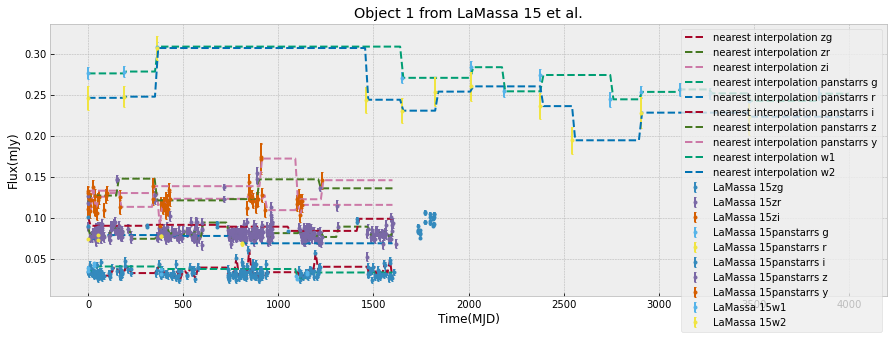

100%|██████████| 1000/1000 [00:35<00:00, 28.55it/s]


In [16]:
"""
1) unify and interpolate on same grid
2) combine all bands into one long array
3) normalize
4) shuffle data and label
"""
# available bands: ['Gaia bp','Gaia rp', 'Gaia g','zg', 'zr', 'zi', 'panstarrs r','panstarrs i', 'panstarrs g', 
#                        'panstarrs z', 'panstarrs y','w1', 'w2' , 'IceCube']
 
bands_inlc = ['zg','zr','zi','panstarrs g','panstarrs r','panstarrs i','panstarrs z', 'panstarrs y','w1', 'w2']

objects,flabels = unify_lc(df_lc,bands_inlc,xres=120,numplots=1)
dat = combine_bands(objects,bands_inlc)
maxarray,meanarray = stat_bands(objects,bands_inlc)
#dat = normalize_objects(dat)
data,fzr,p = shuffle_datalabel(dat,flabels)
maximum_arr,average_arr = maxarray[:,p],meanarray[:,p]

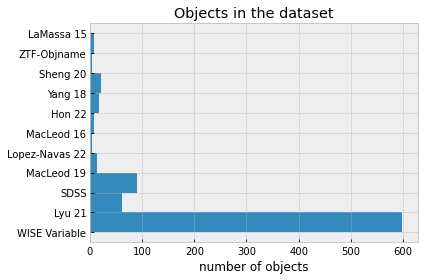

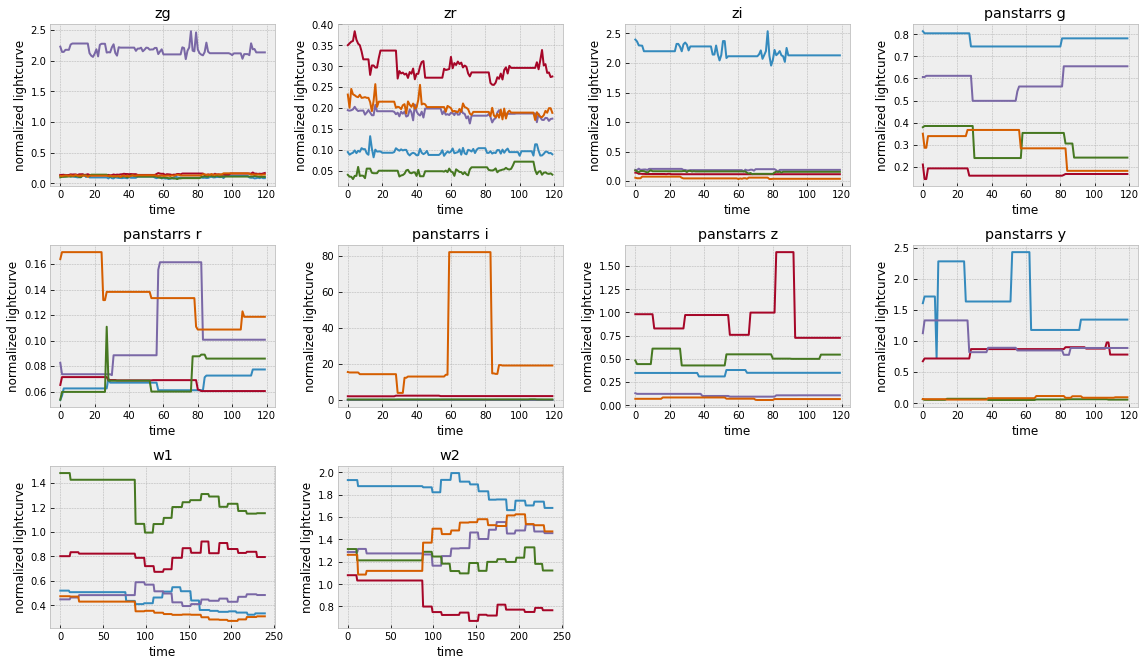

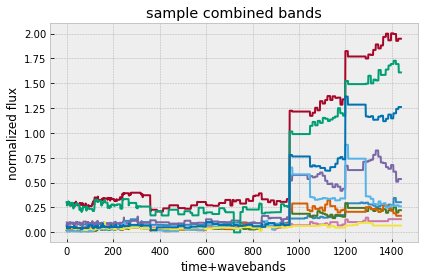

In [17]:
plt.figure(figsize=(6,4))
plt.title("Objects in the dataset")
h = plt.hist(fzr,histtype='stepfilled',orientation='horizontal')
plt.xlabel('number of objects')
plt.tight_layout()

plt.figure(figsize=(16,12))
for b,band in enumerate(bands_inlc):
    for ii in range(5):
        i = np.random.randint(len(objects))
        plt.subplot(4,4,b+1)
        plt.title(band)
        if band=='w1' or band=='w2':
            plt.plot(objects[i,b],label=band)
            plt.xlabel('time')
            plt.ylabel('normalized lightcurve')
        else:
            #print(objects[i,b])
            plt.plot(objects[i,b],label=band)
            plt.xlabel('time')
            plt.ylabel('normalized lightcurve')
plt.tight_layout()

plt.figure(figsize=(6,4))
plt.title("sample combined bands")
for i in range(10):
    ii = np.random.randint(len(data))
    plt.plot(data[ii])
plt.xlabel('time+wavebands')
plt.ylabel('normalized flux')
plt.tight_layout()

# UMAP example

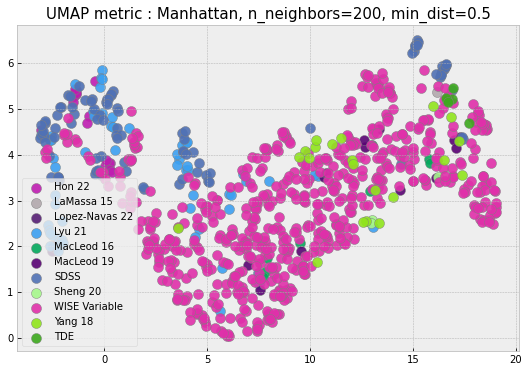

In [18]:
mapperg = umap.UMAP(n_neighbors=200,min_dist=0.5,metric='manhattan',random_state=12).fit(data)

plt.figure(figsize=(9,6))
for l,lab in enumerate(np.unique(fzr)):
    ax0 = plt.subplot(1,1,1)
    ax0.set_title('UMAP metric : Manhattan, n_neighbors=200, min_dist=0.5',size=15)
    u=(fzr[:]==lab)
    if lab=='ZTF-Objname':
        cf = ax0.scatter(mapperg.embedding_[u,0],mapperg.embedding_[u,1],s=100,alpha=0.9,c=np.random.rand(3,).reshape(1,-1),edgecolor='gray',label='TDE')
    else:
        cf = ax0.scatter(mapperg.embedding_[u,0],mapperg.embedding_[u,1],s=100,alpha=0.9,c=np.random.rand(3,).reshape(1,-1),edgecolor='gray',label=lab)
plt.legend()

In [19]:
hover_data = pd.DataFrame({'index':np.arange(len(data)), 'label':fzr,'Gmax':maximum_arr[0,:],'Gmean':average_arr[0,:]})    
p = umap.plot.interactive(mapperg, labels=fzr, hover_data=hover_data, point_size=7, color_key_cmap='fire',background='black',width=800,height=500)
umap.plot.output_notebook()
umap.plot.show(p)


Loading BokehJS ...

<AxesSubplot:>

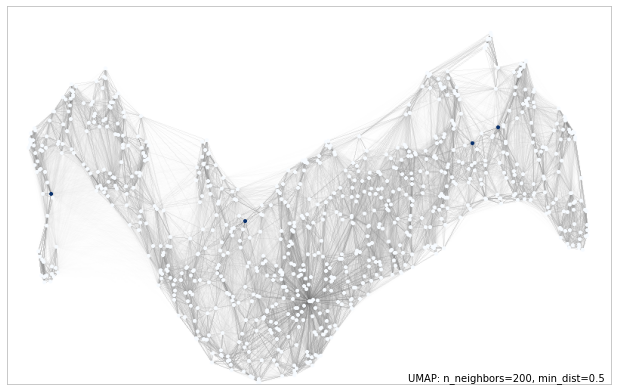

In [20]:
umap.plot.connectivity(mapperg, show_points=True,width=800,height=500)